Pre-process 2161 White Light Images, and parameter features to predict summaries for $U$, $N$ and $B$

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet rich
!pip install --quiet "sunpy[visualization]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 23.9 MB/s eta 0:00:00


In [3]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

In [91]:
args = {
    "niters": 450,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": None,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 64,
    "dropout":False
}

In [5]:
import torch.nn as nn

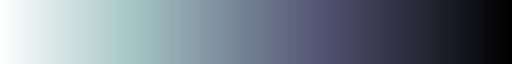

In [6]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [10]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/MyDrive/WLROM/')

import cnn_utils as cu

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Load params and filter out runs by Sim ID Correctly

In [15]:
import os
os.getcwd()

'/content'

In [30]:
cme_params_scaled = pd.read_csv("./drive/MyDrive/WLROM/old_data_surrogate/CMEParams2161_Scaled.csv")
# cme_params_scaled.head()

# rename unnamed column to SimID
cme_params_scaled = cme_params_scaled.rename(columns={'Unnamed: 0': 'SimID'})
# cme_params_scaled = cme_params_scaled.loc[:, ~cme_params_scaled.columns.str.contains('^Unnamed')]
cme_params_scaled.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [31]:
cme_params_scaled.tail()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
273,294,0.875,0.252834,0.622193,0.175,0.0,0.363636,0.352593,0.005643,0.937194
274,295,0.125,0.655648,0.235434,0.475,0.0,0.363636,0.352593,0.005643,0.937194
275,296,0.325,0.518360,0.245710,0.775,1.0,0.363636,0.352593,0.005643,0.937194
276,297,0.925,0.289994,0.829820,0.675,0.0,0.363636,0.352593,0.005643,0.937194
277,298,0.625,0.406615,0.394121,0.375,1.0,0.363636,0.352593,0.005643,0.937194


In [29]:
cme_params_scaled.index

RangeIndex(start=0, stop=278, step=1)

In [23]:
# Load IDs to keep amongst successful runs (1-indexed!)
ids_to_keep_raw = np.load("./drive/MyDrive/WLROM/old_data_surrogate/ids_to_keep_2161.npy")
ids_to_keep = ids_to_keep_raw - 1
ids_to_keep.shape

(254,)

In [53]:
ids_to_keep

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  60,  61,  63,  64,  65,  66,  67,  68,
        69,  71,  72,  73,  74,  75,  76,  77,  79,  80,  81,  87,  88,
        89,  90,  91,  92,  93,  95,  97,  98,  99, 101, 102, 103, 104,
       105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132,
       133, 135, 138, 140, 141, 143, 144, 145, 147, 148, 149, 152, 153,
       154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 170,
       171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 191, 192, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 21

In [52]:
successful_sim_ids = cme_params_scaled['SimID'].to_numpy()
successful_sim_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  79,
        80,  81,  82,  83,  84,  87,  88,  89,  90,  91,  92,  93,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137,
       138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152,
       153, 154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 19

In [55]:
# find indices of successful sim IDs to keep
indices_to_keep = np.where(np.isin(successful_sim_ids, ids_to_keep))[0]
indices_to_keep.shape

(254,)

In [74]:
# np.linspace(0, 277, 278, dtype=int)[ids_to_keep]

In [34]:
filtered_df = cme_params_scaled[cme_params_scaled['SimID'].isin(ids_to_keep)]
filtered_df.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [36]:
filtered_df.shape

(254, 10)

In [80]:
# remove simID column and convert to numpy
cme_params_np = filtered_df.iloc[:, 1:].to_numpy()
cme_params_np.shape

(254, 9)

Similarly load raw data and filter out runs by SimID correctly.

In [43]:
raw_images = np.load("./drive/MyDrive/WLROM/old_data_surrogate/CR2161_tDecay2h_Polar_Compressed.npy")

In [44]:
raw_images.shape

(64, 256, 90, 278)

In [72]:
raw_images_to_keep = raw_images[:62, :, :, indices_to_keep]
raw_images_to_keep.shape

(62, 256, 90, 254)

In [73]:
raw_min, raw_max = raw_images_to_keep.min(), raw_images_to_keep.max()
raw_min, raw_max

(0.9140037834350702, 1.5)

Load summary stats and process

In [41]:
summary_stats_raw = pd.read_csv("./drive/MyDrive/WLROM/old_data_surrogate/SummaryStats_2161Old.csv")
summary_stats_raw.head(), summary_stats_raw.shape

(   SIMID       summU      summN      summB  summArr
 0     31  753.379514  14.740539   5.474132     30.0
 1     32  543.552620  15.089102   8.494696     57.0
 2     33  619.406555  13.467365   8.892779     62.0
 3     34  467.688730  12.598024   6.808105     58.0
 4     35  651.469120  26.994850  11.082531     49.0,
 (254, 5))

In [67]:
# convert last 4 cols of summary stats to numpy
summary_stats_np = summary_stats_raw.iloc[:, 1:].to_numpy()
summary_stats_np.shape

(254, 4)

In [60]:
num_sim = len(indices_to_keep)
num_sim

254

In [61]:
data_sim_ids = np.linspace(0, num_sim - 1, num_sim, dtype=int)

In [63]:
generator1 = torch.Generator().manual_seed(2024)
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_valid_test = random_split(data_sim_ids,
                                [train_frac, val_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)

In [68]:
train_idx = np.array(train_valid_test[0].indices)
val_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [69]:
ntrain = train_idx.shape[0]
nval = val_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(178, 26, 50)

In [75]:
train_data_raw = raw_images_to_keep[:, :, :, train_idx]
val_data_raw = raw_images_to_keep[:, :, :, val_idx]
test_data_raw = raw_images_to_keep[:, :, :, test_idx]

In [76]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))

val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [78]:
train_data_resized.shape

torch.Size([178, 90, 16, 64])

In [77]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.9356))

In [66]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [79]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [81]:
train_params_raw = cme_params_np[train_idx, :]
valid_params_raw = cme_params_np[val_idx, :]
test_params_raw = cme_params_np[test_idx, :]

In [96]:
train_snaps.shape

torch.Size([178, 40, 1024])

In [98]:
ntrain

178

In [105]:
expanded_tpredict_train = tpredict.view(1, nTimesteps, 1).expand(ntrain, nTimesteps, -1)
expanded_tpredict_val = tpredict.view(1, nTimesteps, 1).expand(nval, nTimesteps, -1)
expanded_tpredict_test = tpredict.view(1, nTimesteps, 1).expand(ntest, nTimesteps, -1)

In [106]:
expanded_tpredict_train.shape

torch.Size([178, 40, 1])

In [107]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# reshape tpredict to be the same dimensions as train snaps etc.

train_snaps_concat = torch.cat((train_snaps, expanded_tpredict_train), 2)
val_snaps_concat = torch.cat((val_snaps, expanded_tpredict_val), 2)
test_snaps_concat = torch.cat((test_snaps, expanded_tpredict_test), 2)

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps_concat, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps_concat, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps_concat, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [108]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([178, 40, 1034]),
 torch.Size([26, 40, 1034]),
 torch.Size([50, 40, 1034]))

In [ ]:
# concatenate times from tPredict to the last dimension for train_snaps, val_snaps, and test_snaps

In [70]:
import sklearn
import copy
train_arr_raw = summary_stats_np[train_idx, :]
val_arr_raw = summary_stats_np[val_idx, :]
test_arr_raw = summary_stats_np[test_idx, :]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
# pt = sklearn.preprocessing.RobustScaler()
pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw)

train_arr_pt = pt.transform(train_arr_raw)
val_arr_pt = pt.transform(val_arr_raw)
test_arr_pt = pt.transform(test_arr_raw)

(178, 4) (26, 4) (50, 4)


In [109]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw).unsqueeze(1)
val_arr_raw_ts = torch.Tensor(val_arr_raw).unsqueeze(1)
test_arr_raw_ts = torch.Tensor(test_arr_raw).unsqueeze(1)

In [110]:
train_dataset = []
val_dataset = []
test_dataset = []
for i in range(ntrain):
    for j in range(1, nTimesteps - 1):
        train_dataset.append((train_all[i:(i+1), (j-1):(j+2), :], train_arr_ts[i, :], train_arr_raw_ts[i, :]))

for i in range(nval):
    for j in range(1, nTimesteps - 1):
        val_dataset.append((val_all[i:(i+1), (j-1):(j+2), :], val_arr_ts[i, :], val_arr_raw_ts[i, :]))

for i in range(ntest):
    for j in range(1, nTimesteps - 1):
        test_dataset.append((test_all[i:(i+1), (j-1):(j+2), :], test_arr_ts[i, :], test_arr_raw_ts[i, :]))

In [111]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = args["batch_size"],
                              shuffle=True,
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [112]:
len(train_dataset), len(val_dataset), len(test_dataset)

(6764, 988, 1900)

In [94]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [123]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def update_learning_rate(optimizer, decay_rate = 0.999, lowest = 1e-3):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        lr = max(lr * decay_rate, lowest)
        param_group['lr'] = lr

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def save_checkpoint(state, save, epoch):
    if not os.path.exists(save):
        os.makedirs(save)
    filename = os.path.join(save, 'checkpt-%04d.pth' % epoch)
    torch.save(state, filename)

def get_ckpt_model(ckpt_path, model, optimizer, device):
    if not os.path.exists(ckpt_path):
        raise Exception("Checkpoint " + ckpt_path + " does not exist.")
    # Load checkpoint.
    checkpt = torch.load(ckpt_path, map_location=device)
    # # ckpt_args = checkpt['args']

    model_dict = model.state_dict()
    state_dict = checkpt['model']

    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict)
    # 3. load the new state dict
    model.load_state_dict(state_dict)

    # Load optimizer state.
    optimizer.load_state_dict(checkpt['optimizer_state'])

    model.to(device)
    # optimizer.to(device)

def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)

    return logger


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0,
                 path="/Users/ajivani/Desktop/Research/WLROM/WhiteLight/model_stopping/model_state.pt",
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args):

        # score = -val_loss
        score = -all_valid_loss[-1]

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args)
            self.counter = 0

    def save_checkpoint(self, val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            # self.trace_func(f'Val loss decreased ({self.val_loss_min:.2f} to {val_loss:.2f}). Model saved')
            self.trace_func(f'Val loss decreased ({self.val_loss_min:.2f} to {all_valid_loss[-1]:.2f}). Model saved')


        torch.save({'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args,
                    },
                    self.path)
        # torch.save(model.state_dict(), self.path)
        # self.val_loss_min = val_loss
        self.val_loss_min = all_valid_loss[-1]


In [126]:
class WLCNN_Discrete(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1284 + in_channels + 5, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 4)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1025:]
        x_t = x[:, 0, :, 1024]

        x_ft = self.features(x_ip)

        x_ft = torch.flatten(x_ft, 1)

        x_ft_cat = torch.cat((x_ft, x_t, x_param), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

In [127]:
# !pip install --quiet torchdiffeq
import pandas as pd
# import node_utils as nut
# import data_utils as dut
# import copy

In [128]:
model = WLCNN_Discrete(n_hidden_1=16,
                       n_hidden_2=8).to(device)
pmodel = count_parameters(model)


print("Total number of parameters for model with concatenation: ", pmodel)

makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint path: ", ckpt_path)

logger = get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

INFO:root:/content
/content
/content
INFO:root:WLCNN_Discrete(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1292, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ELU(alpha=1.0)


Total number of parameters for model with concatenation:  24396
Starting New experiment
Experiment ID:  97258
Checkpoint path:  /content/arr_experiments/experiment_97258.ckpt


Concatenate time-of-frame with features

In [129]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])

        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, all_valid_loss, all_train_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save({'epoch': itr,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args},
                    os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    # check if early stopped model is available!
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt")

    if os.path.exists(early_stop_filepath):
        if args["load"] == 56:
            early_stp_ckpt = torch.load(early_stop_filepath)
            model.load_state_dict(early_stp_ckpt)
        else:
            get_ckpt_model(early_stop_filepath, model, optimizer, device)
        print("Loading early stopped model ID {} from {}".format(experimentID, early_stop_filepath))
    else:
        get_ckpt_model(ckpt_path, model, optimizer, device)
        print("Loading existing model ID {} from {}".format(experimentID, ckpt_path))

Output()

L1Loss()
Starting a new experiment 97258 from Epoch 0


INFO:root:Epoch 0001|Val loss 1.746047e-01|Train loss 3.644094e-01|LR 0.00100|
Epoch 0001|Val loss 1.746047e-01|Train loss 3.644094e-01|LR 0.00100|
Epoch 0001|Val loss 1.746047e-01|Train loss 3.644094e-01|LR 0.00100|
INFO:root:Epoch 0002|Val loss 1.820629e-01|Train loss 2.242003e-01|LR 0.00100|
Epoch 0002|Val loss 1.820629e-01|Train loss 2.242003e-01|LR 0.00100|
Epoch 0002|Val loss 1.820629e-01|Train loss 2.242003e-01|LR 0.00100|
INFO:root:Epoch 0003|Val loss 1.341128e-01|Train loss 1.793833e-01|LR 0.00100|
Epoch 0003|Val loss 1.341128e-01|Train loss 1.793833e-01|LR 0.00100|
Epoch 0003|Val loss 1.341128e-01|Train loss 1.793833e-01|LR 0.00100|
INFO:root:Epoch 0004|Val loss 1.547682e-01|Train loss 1.581601e-01|LR 0.00100|
Epoch 0004|Val loss 1.547682e-01|Train loss 1.581601e-01|LR 0.00100|
Epoch 0004|Val loss 1.547682e-01|Train loss 1.581601e-01|LR 0.00100|
INFO:root:Epoch 0005|Val loss 1.223705e-01|Train loss 1.464092e-01|LR 0.00100|
Epoch 0005|Val loss 1.223705e-01|Train loss 1.464092e

Val loss decreased (inf to 0.13). Model saved

INFO:root:Epoch 0011|Val loss 1.275078e-01|Train loss 1.264012e-01|LR 0.00100|
Epoch 0011|Val loss 1.275078e-01|Train loss 1.264012e-01|LR 0.00100|
Epoch 0011|Val loss 1.275078e-01|Train loss 1.264012e-01|LR 0.00100|
INFO:root:Epoch 0012|Val loss 1.384353e-01|Train loss 1.273029e-01|LR 0.00100|
Epoch 0012|Val loss 1.384353e-01|Train loss 1.273029e-01|LR 0.00100|
Epoch 0012|Val loss 1.384353e-01|Train loss 1.273029e-01|LR 0.00100|
INFO:root:Epoch 0013|Val loss 1.218463e-01|Train loss 1.266774e-01|LR 0.00100|
Epoch 0013|Val loss 1.218463e-01|Train loss 1.266774e-01|LR 0.00100|
Epoch 0013|Val loss 1.218463e-01|Train loss 1.266774e-01|LR 0.00100|
INFO:root:Epoch 0014|Val loss 1.149527e-01|Train loss 1.233898e-01|LR 0.00100|
Epoch 0014|Val loss 1.149527e-01|Train loss 1.233898e-01|LR 0.00100|
Epoch 0014|Val loss 1.149527e-01|Train loss 1.233898e-01|LR 0.00100|
INFO:root:Epoch 0015|Val loss 1.245231e-01|Train loss 1.240030e-01|LR 0.00100|
Epoch 0015|Val loss 1.245231e-01|Train loss 1.240030e

Val loss decreased (0.13 to 0.11). Model saved

INFO:root:Epoch 0021|Val loss 9.633069e-02|Train loss 1.178126e-01|LR 0.00100|
Epoch 0021|Val loss 9.633069e-02|Train loss 1.178126e-01|LR 0.00100|
Epoch 0021|Val loss 9.633069e-02|Train loss 1.178126e-01|LR 0.00100|
INFO:root:Epoch 0022|Val loss 1.033448e-01|Train loss 1.177011e-01|LR 0.00100|
Epoch 0022|Val loss 1.033448e-01|Train loss 1.177011e-01|LR 0.00100|
Epoch 0022|Val loss 1.033448e-01|Train loss 1.177011e-01|LR 0.00100|
INFO:root:Epoch 0023|Val loss 9.851985e-02|Train loss 1.180474e-01|LR 0.00100|
Epoch 0023|Val loss 9.851985e-02|Train loss 1.180474e-01|LR 0.00100|
Epoch 0023|Val loss 9.851985e-02|Train loss 1.180474e-01|LR 0.00100|
INFO:root:Epoch 0024|Val loss 1.047349e-01|Train loss 1.184280e-01|LR 0.00100|
Epoch 0024|Val loss 1.047349e-01|Train loss 1.184280e-01|LR 0.00100|
Epoch 0024|Val loss 1.047349e-01|Train loss 1.184280e-01|LR 0.00100|
INFO:root:Epoch 0025|Val loss 1.069351e-01|Train loss 1.218827e-01|LR 0.00100|
Epoch 0025|Val loss 1.069351e-01|Train loss 1.218827e

EarlyStopping counter: 1 out of 20

INFO:root:Epoch 0031|Val loss 1.019657e-01|Train loss 1.242272e-01|LR 0.00100|
Epoch 0031|Val loss 1.019657e-01|Train loss 1.242272e-01|LR 0.00100|
Epoch 0031|Val loss 1.019657e-01|Train loss 1.242272e-01|LR 0.00100|
INFO:root:Epoch 0032|Val loss 1.139589e-01|Train loss 1.233253e-01|LR 0.00100|
Epoch 0032|Val loss 1.139589e-01|Train loss 1.233253e-01|LR 0.00100|
Epoch 0032|Val loss 1.139589e-01|Train loss 1.233253e-01|LR 0.00100|
INFO:root:Epoch 0033|Val loss 1.035740e-01|Train loss 1.223772e-01|LR 0.00100|
Epoch 0033|Val loss 1.035740e-01|Train loss 1.223772e-01|LR 0.00100|
Epoch 0033|Val loss 1.035740e-01|Train loss 1.223772e-01|LR 0.00100|
INFO:root:Epoch 0034|Val loss 1.056792e-01|Train loss 1.195605e-01|LR 0.00100|
Epoch 0034|Val loss 1.056792e-01|Train loss 1.195605e-01|LR 0.00100|
Epoch 0034|Val loss 1.056792e-01|Train loss 1.195605e-01|LR 0.00100|
INFO:root:Epoch 0035|Val loss 9.802537e-02|Train loss 1.170238e-01|LR 0.00100|
Epoch 0035|Val loss 9.802537e-02|Train loss 1.170238e

EarlyStopping counter: 2 out of 20

INFO:root:Epoch 0041|Val loss 1.228111e-01|Train loss 1.176744e-01|LR 0.00100|
Epoch 0041|Val loss 1.228111e-01|Train loss 1.176744e-01|LR 0.00100|
Epoch 0041|Val loss 1.228111e-01|Train loss 1.176744e-01|LR 0.00100|
INFO:root:Epoch 0042|Val loss 1.115259e-01|Train loss 1.169621e-01|LR 0.00100|
Epoch 0042|Val loss 1.115259e-01|Train loss 1.169621e-01|LR 0.00100|
INFO:root:Epoch 0043|Val loss 1.042778e-01|Train loss 1.186064e-01|LR 0.00100|
Epoch 0043|Val loss 1.042778e-01|Train loss 1.186064e-01|LR 0.00100|
Epoch 0043|Val loss 1.042778e-01|Train loss 1.186064e-01|LR 0.00100|
INFO:root:Epoch 0044|Val loss 1.084587e-01|Train loss 1.196308e-01|LR 0.00100|
Epoch 0044|Val loss 1.084587e-01|Train loss 1.196308e-01|LR 0.00100|
Epoch 0044|Val loss 1.084587e-01|Train loss 1.196308e-01|LR 0.00100|
INFO:root:Epoch 0045|Val loss 9.492458e-02|Train loss 1.189166e-01|LR 0.00100|
Epoch 0045|Val loss 9.492458e-02|Train loss 1.189166e-01|LR 0.00100|
Epoch 0045|Val loss 9.492458e-02|Train loss 1.189166e

EarlyStopping counter: 3 out of 20

INFO:root:Epoch 0051|Val loss 1.036923e-01|Train loss 1.179936e-01|LR 0.00100|
Epoch 0051|Val loss 1.036923e-01|Train loss 1.179936e-01|LR 0.00100|
Epoch 0051|Val loss 1.036923e-01|Train loss 1.179936e-01|LR 0.00100|
INFO:root:Epoch 0052|Val loss 1.198960e-01|Train loss 1.176095e-01|LR 0.00100|
Epoch 0052|Val loss 1.198960e-01|Train loss 1.176095e-01|LR 0.00100|
Epoch 0052|Val loss 1.198960e-01|Train loss 1.176095e-01|LR 0.00100|
INFO:root:Epoch 0053|Val loss 9.661381e-02|Train loss 1.204873e-01|LR 0.00100|
Epoch 0053|Val loss 9.661381e-02|Train loss 1.204873e-01|LR 0.00100|
Epoch 0053|Val loss 9.661381e-02|Train loss 1.204873e-01|LR 0.00100|
INFO:root:Epoch 0054|Val loss 1.095968e-01|Train loss 1.130597e-01|LR 0.00100|
Epoch 0054|Val loss 1.095968e-01|Train loss 1.130597e-01|LR 0.00100|
Epoch 0054|Val loss 1.095968e-01|Train loss 1.130597e-01|LR 0.00100|
INFO:root:Epoch 0055|Val loss 1.042287e-01|Train loss 1.151119e-01|LR 0.00100|
Epoch 0055|Val loss 1.042287e-01|Train loss 1.151119e

Val loss decreased (0.11 to 0.10). Model saved

INFO:root:Epoch 0061|Val loss 1.084289e-01|Train loss 1.150676e-01|LR 0.00100|
Epoch 0061|Val loss 1.084289e-01|Train loss 1.150676e-01|LR 0.00100|
Epoch 0061|Val loss 1.084289e-01|Train loss 1.150676e-01|LR 0.00100|
INFO:root:Epoch 0062|Val loss 1.119228e-01|Train loss 1.156076e-01|LR 0.00100|
Epoch 0062|Val loss 1.119228e-01|Train loss 1.156076e-01|LR 0.00100|
Epoch 0062|Val loss 1.119228e-01|Train loss 1.156076e-01|LR 0.00100|
INFO:root:Epoch 0063|Val loss 9.260611e-02|Train loss 1.200697e-01|LR 0.00100|
Epoch 0063|Val loss 9.260611e-02|Train loss 1.200697e-01|LR 0.00100|
Epoch 0063|Val loss 9.260611e-02|Train loss 1.200697e-01|LR 0.00100|
INFO:root:Epoch 0064|Val loss 1.117246e-01|Train loss 1.154670e-01|LR 0.00100|
Epoch 0064|Val loss 1.117246e-01|Train loss 1.154670e-01|LR 0.00100|
Epoch 0064|Val loss 1.117246e-01|Train loss 1.154670e-01|LR 0.00100|
INFO:root:Epoch 0065|Val loss 1.055586e-01|Train loss 1.180659e-01|LR 0.00100|
Epoch 0065|Val loss 1.055586e-01|Train loss 1.180659e

EarlyStopping counter: 1 out of 20

INFO:root:Epoch 0071|Val loss 1.002698e-01|Train loss 1.167058e-01|LR 0.00100|
Epoch 0071|Val loss 1.002698e-01|Train loss 1.167058e-01|LR 0.00100|
Epoch 0071|Val loss 1.002698e-01|Train loss 1.167058e-01|LR 0.00100|
INFO:root:Epoch 0072|Val loss 1.211691e-01|Train loss 1.158752e-01|LR 0.00100|
Epoch 0072|Val loss 1.211691e-01|Train loss 1.158752e-01|LR 0.00100|
Epoch 0072|Val loss 1.211691e-01|Train loss 1.158752e-01|LR 0.00100|
INFO:root:Epoch 0073|Val loss 8.746296e-02|Train loss 1.209118e-01|LR 0.00100|
Epoch 0073|Val loss 8.746296e-02|Train loss 1.209118e-01|LR 0.00100|
Epoch 0073|Val loss 8.746296e-02|Train loss 1.209118e-01|LR 0.00100|
INFO:root:Epoch 0074|Val loss 1.219059e-01|Train loss 1.168223e-01|LR 0.00100|
Epoch 0074|Val loss 1.219059e-01|Train loss 1.168223e-01|LR 0.00100|
Epoch 0074|Val loss 1.219059e-01|Train loss 1.168223e-01|LR 0.00100|
INFO:root:Epoch 0075|Val loss 9.231489e-02|Train loss 1.175347e-01|LR 0.00100|
Epoch 0075|Val loss 9.231489e-02|Train loss 1.175347e

EarlyStopping counter: 2 out of 20

INFO:root:Epoch 0081|Val loss 9.019166e-02|Train loss 1.200555e-01|LR 0.00100|
Epoch 0081|Val loss 9.019166e-02|Train loss 1.200555e-01|LR 0.00100|
Epoch 0081|Val loss 9.019166e-02|Train loss 1.200555e-01|LR 0.00100|
INFO:root:Epoch 0082|Val loss 1.222344e-01|Train loss 1.161504e-01|LR 0.00100|
Epoch 0082|Val loss 1.222344e-01|Train loss 1.161504e-01|LR 0.00100|
Epoch 0082|Val loss 1.222344e-01|Train loss 1.161504e-01|LR 0.00100|
INFO:root:Epoch 0083|Val loss 8.812891e-02|Train loss 1.157993e-01|LR 0.00100|
Epoch 0083|Val loss 8.812891e-02|Train loss 1.157993e-01|LR 0.00100|
Epoch 0083|Val loss 8.812891e-02|Train loss 1.157993e-01|LR 0.00100|
INFO:root:Epoch 0084|Val loss 1.292099e-01|Train loss 1.140292e-01|LR 0.00100|
Epoch 0084|Val loss 1.292099e-01|Train loss 1.140292e-01|LR 0.00100|
Epoch 0084|Val loss 1.292099e-01|Train loss 1.140292e-01|LR 0.00100|
INFO:root:Epoch 0085|Val loss 9.469443e-02|Train loss 1.164706e-01|LR 0.00100|
Epoch 0085|Val loss 9.469443e-02|Train loss 1.164706e

EarlyStopping counter: 3 out of 20

INFO:root:Epoch 0091|Val loss 9.113076e-02|Train loss 1.143686e-01|LR 0.00100|
Epoch 0091|Val loss 9.113076e-02|Train loss 1.143686e-01|LR 0.00100|
Epoch 0091|Val loss 9.113076e-02|Train loss 1.143686e-01|LR 0.00100|
INFO:root:Epoch 0092|Val loss 1.279234e-01|Train loss 1.122090e-01|LR 0.00100|
Epoch 0092|Val loss 1.279234e-01|Train loss 1.122090e-01|LR 0.00100|
Epoch 0092|Val loss 1.279234e-01|Train loss 1.122090e-01|LR 0.00100|
INFO:root:Epoch 0093|Val loss 1.052532e-01|Train loss 1.136087e-01|LR 0.00100|
Epoch 0093|Val loss 1.052532e-01|Train loss 1.136087e-01|LR 0.00100|
Epoch 0093|Val loss 1.052532e-01|Train loss 1.136087e-01|LR 0.00100|
INFO:root:Epoch 0094|Val loss 1.089410e-01|Train loss 1.136659e-01|LR 0.00100|
Epoch 0094|Val loss 1.089410e-01|Train loss 1.136659e-01|LR 0.00100|
Epoch 0094|Val loss 1.089410e-01|Train loss 1.136659e-01|LR 0.00100|
INFO:root:Epoch 0095|Val loss 8.386149e-02|Train loss 1.149085e-01|LR 0.00100|
Epoch 0095|Val loss 8.386149e-02|Train loss 1.149085e

EarlyStopping counter: 4 out of 20

INFO:root:Epoch 0101|Val loss 9.705105e-02|Train loss 1.117615e-01|LR 0.00100|
Epoch 0101|Val loss 9.705105e-02|Train loss 1.117615e-01|LR 0.00100|
Epoch 0101|Val loss 9.705105e-02|Train loss 1.117615e-01|LR 0.00100|
INFO:root:Epoch 0102|Val loss 1.041186e-01|Train loss 1.131509e-01|LR 0.00100|
Epoch 0102|Val loss 1.041186e-01|Train loss 1.131509e-01|LR 0.00100|
Epoch 0102|Val loss 1.041186e-01|Train loss 1.131509e-01|LR 0.00100|
INFO:root:Epoch 0103|Val loss 8.162513e-02|Train loss 1.160353e-01|LR 0.00100|
Epoch 0103|Val loss 8.162513e-02|Train loss 1.160353e-01|LR 0.00100|
Epoch 0103|Val loss 8.162513e-02|Train loss 1.160353e-01|LR 0.00100|
INFO:root:Epoch 0104|Val loss 1.059034e-01|Train loss 1.101969e-01|LR 0.00100|
Epoch 0104|Val loss 1.059034e-01|Train loss 1.101969e-01|LR 0.00100|
Epoch 0104|Val loss 1.059034e-01|Train loss 1.101969e-01|LR 0.00100|
INFO:root:Epoch 0105|Val loss 9.559783e-02|Train loss 1.097963e-01|LR 0.00100|
Epoch 0105|Val loss 9.559783e-02|Train loss 1.097963e

EarlyStopping counter: 5 out of 20

INFO:root:Epoch 0111|Val loss 8.252365e-02|Train loss 1.129891e-01|LR 0.00100|
Epoch 0111|Val loss 8.252365e-02|Train loss 1.129891e-01|LR 0.00100|
Epoch 0111|Val loss 8.252365e-02|Train loss 1.129891e-01|LR 0.00100|
INFO:root:Epoch 0112|Val loss 1.124154e-01|Train loss 1.125562e-01|LR 0.00100|
Epoch 0112|Val loss 1.124154e-01|Train loss 1.125562e-01|LR 0.00100|
Epoch 0112|Val loss 1.124154e-01|Train loss 1.125562e-01|LR 0.00100|
INFO:root:Epoch 0113|Val loss 9.518396e-02|Train loss 1.129749e-01|LR 0.00100|
Epoch 0113|Val loss 9.518396e-02|Train loss 1.129749e-01|LR 0.00100|
Epoch 0113|Val loss 9.518396e-02|Train loss 1.129749e-01|LR 0.00100|
INFO:root:Epoch 0114|Val loss 1.105154e-01|Train loss 1.115256e-01|LR 0.00100|
Epoch 0114|Val loss 1.105154e-01|Train loss 1.115256e-01|LR 0.00100|
Epoch 0114|Val loss 1.105154e-01|Train loss 1.115256e-01|LR 0.00100|
INFO:root:Epoch 0115|Val loss 8.633007e-02|Train loss 1.136634e-01|LR 0.00100|
Epoch 0115|Val loss 8.633007e-02|Train loss 1.136634e

EarlyStopping counter: 6 out of 20

INFO:root:Epoch 0122|Val loss 1.201139e-01|Train loss 1.126742e-01|LR 0.00100|
Epoch 0122|Val loss 1.201139e-01|Train loss 1.126742e-01|LR 0.00100|
Epoch 0122|Val loss 1.201139e-01|Train loss 1.126742e-01|LR 0.00100|
INFO:root:Epoch 0123|Val loss 9.560782e-02|Train loss 1.147996e-01|LR 0.00100|
Epoch 0123|Val loss 9.560782e-02|Train loss 1.147996e-01|LR 0.00100|
Epoch 0123|Val loss 9.560782e-02|Train loss 1.147996e-01|LR 0.00100|
INFO:root:Epoch 0124|Val loss 1.120255e-01|Train loss 1.122392e-01|LR 0.00100|
Epoch 0124|Val loss 1.120255e-01|Train loss 1.122392e-01|LR 0.00100|
Epoch 0124|Val loss 1.120255e-01|Train loss 1.122392e-01|LR 0.00100|
INFO:root:Epoch 0125|Val loss 9.483007e-02|Train loss 1.117810e-01|LR 0.00100|
Epoch 0125|Val loss 9.483007e-02|Train loss 1.117810e-01|LR 0.00100|
Epoch 0125|Val loss 9.483007e-02|Train loss 1.117810e-01|LR 0.00100|
INFO:root:Epoch 0126|Val loss 1.152503e-01|Train loss 1.116080e-01|LR 0.00100|
Epoch 0126|Val loss 1.152503e-01|Train loss 1.116080e

EarlyStopping counter: 7 out of 20

INFO:root:Epoch 0131|Val loss 8.505070e-02|Train loss 1.153710e-01|LR 0.00100|
Epoch 0131|Val loss 8.505070e-02|Train loss 1.153710e-01|LR 0.00100|
Epoch 0131|Val loss 8.505070e-02|Train loss 1.153710e-01|LR 0.00100|
INFO:root:Epoch 0132|Val loss 1.130520e-01|Train loss 1.096688e-01|LR 0.00100|
Epoch 0132|Val loss 1.130520e-01|Train loss 1.096688e-01|LR 0.00100|
Epoch 0132|Val loss 1.130520e-01|Train loss 1.096688e-01|LR 0.00100|
INFO:root:Epoch 0133|Val loss 9.300897e-02|Train loss 1.108516e-01|LR 0.00100|
Epoch 0133|Val loss 9.300897e-02|Train loss 1.108516e-01|LR 0.00100|
Epoch 0133|Val loss 9.300897e-02|Train loss 1.108516e-01|LR 0.00100|
INFO:root:Epoch 0134|Val loss 1.139984e-01|Train loss 1.111916e-01|LR 0.00100|
Epoch 0134|Val loss 1.139984e-01|Train loss 1.111916e-01|LR 0.00100|
Epoch 0134|Val loss 1.139984e-01|Train loss 1.111916e-01|LR 0.00100|
INFO:root:Epoch 0135|Val loss 9.734993e-02|Train loss 1.129481e-01|LR 0.00100|
Epoch 0135|Val loss 9.734993e-02|Train loss 1.129481e

EarlyStopping counter: 8 out of 20

INFO:root:Epoch 0141|Val loss 9.111388e-02|Train loss 1.043001e-01|LR 0.00100|
Epoch 0141|Val loss 9.111388e-02|Train loss 1.043001e-01|LR 0.00100|
Epoch 0141|Val loss 9.111388e-02|Train loss 1.043001e-01|LR 0.00100|
INFO:root:Epoch 0142|Val loss 1.060883e-01|Train loss 1.074551e-01|LR 0.00100|
Epoch 0142|Val loss 1.060883e-01|Train loss 1.074551e-01|LR 0.00100|
Epoch 0142|Val loss 1.060883e-01|Train loss 1.074551e-01|LR 0.00100|
INFO:root:Epoch 0143|Val loss 9.222482e-02|Train loss 1.106187e-01|LR 0.00100|
Epoch 0143|Val loss 9.222482e-02|Train loss 1.106187e-01|LR 0.00100|
Epoch 0143|Val loss 9.222482e-02|Train loss 1.106187e-01|LR 0.00100|
INFO:root:Epoch 0144|Val loss 1.169653e-01|Train loss 1.103921e-01|LR 0.00100|
Epoch 0144|Val loss 1.169653e-01|Train loss 1.103921e-01|LR 0.00100|
Epoch 0144|Val loss 1.169653e-01|Train loss 1.103921e-01|LR 0.00100|
INFO:root:Epoch 0145|Val loss 9.121924e-02|Train loss 1.142365e-01|LR 0.00100|
Epoch 0145|Val loss 9.121924e-02|Train loss 1.142365e

EarlyStopping counter: 9 out of 20

INFO:root:Epoch 0151|Val loss 8.634266e-02|Train loss 1.126470e-01|LR 0.00100|
Epoch 0151|Val loss 8.634266e-02|Train loss 1.126470e-01|LR 0.00100|
Epoch 0151|Val loss 8.634266e-02|Train loss 1.126470e-01|LR 0.00100|
INFO:root:Epoch 0152|Val loss 1.186430e-01|Train loss 1.142668e-01|LR 0.00100|
Epoch 0152|Val loss 1.186430e-01|Train loss 1.142668e-01|LR 0.00100|
Epoch 0152|Val loss 1.186430e-01|Train loss 1.142668e-01|LR 0.00100|
INFO:root:Epoch 0153|Val loss 8.871235e-02|Train loss 1.185011e-01|LR 0.00100|
Epoch 0153|Val loss 8.871235e-02|Train loss 1.185011e-01|LR 0.00100|
Epoch 0153|Val loss 8.871235e-02|Train loss 1.185011e-01|LR 0.00100|
INFO:root:Epoch 0154|Val loss 1.180327e-01|Train loss 1.105352e-01|LR 0.00100|
Epoch 0154|Val loss 1.180327e-01|Train loss 1.105352e-01|LR 0.00100|
Epoch 0154|Val loss 1.180327e-01|Train loss 1.105352e-01|LR 0.00100|
INFO:root:Epoch 0155|Val loss 9.305809e-02|Train loss 1.146848e-01|LR 0.00100|
Epoch 0155|Val loss 9.305809e-02|Train loss 1.146848e

EarlyStopping counter: 10 out of 20

INFO:root:Epoch 0161|Val loss 1.050609e-01|Train loss 1.152528e-01|LR 0.00100|
Epoch 0161|Val loss 1.050609e-01|Train loss 1.152528e-01|LR 0.00100|
Epoch 0161|Val loss 1.050609e-01|Train loss 1.152528e-01|LR 0.00100|
INFO:root:Epoch 0162|Val loss 1.171297e-01|Train loss 1.151856e-01|LR 0.00100|
Epoch 0162|Val loss 1.171297e-01|Train loss 1.151856e-01|LR 0.00100|
Epoch 0162|Val loss 1.171297e-01|Train loss 1.151856e-01|LR 0.00100|
INFO:root:Epoch 0163|Val loss 9.733070e-02|Train loss 1.152439e-01|LR 0.00100|
Epoch 0163|Val loss 9.733070e-02|Train loss 1.152439e-01|LR 0.00100|
Epoch 0163|Val loss 9.733070e-02|Train loss 1.152439e-01|LR 0.00100|
INFO:root:Epoch 0164|Val loss 1.098761e-01|Train loss 1.135984e-01|LR 0.00100|
Epoch 0164|Val loss 1.098761e-01|Train loss 1.135984e-01|LR 0.00100|
Epoch 0164|Val loss 1.098761e-01|Train loss 1.135984e-01|LR 0.00100|
INFO:root:Epoch 0165|Val loss 9.904694e-02|Train loss 1.148758e-01|LR 0.00100|
Epoch 0165|Val loss 9.904694e-02|Train loss 1.148758e

Val loss decreased (0.10 to 0.10). Model saved

Epoch 0171|Val loss 9.134003e-02|Train loss 1.078797e-01|LR 0.00100|
Epoch 0171|Val loss 9.134003e-02|Train loss 1.078797e-01|LR 0.00100|
INFO:root:Epoch 0172|Val loss 1.086357e-01|Train loss 1.049562e-01|LR 0.00100|
Epoch 0172|Val loss 1.086357e-01|Train loss 1.049562e-01|LR 0.00100|
Epoch 0172|Val loss 1.086357e-01|Train loss 1.049562e-01|LR 0.00100|
INFO:root:Epoch 0173|Val loss 9.636292e-02|Train loss 1.073876e-01|LR 0.00100|
Epoch 0173|Val loss 9.636292e-02|Train loss 1.073876e-01|LR 0.00100|
Epoch 0173|Val loss 9.636292e-02|Train loss 1.073876e-01|LR 0.00100|
INFO:root:Epoch 0174|Val loss 1.045921e-01|Train loss 1.056757e-01|LR 0.00100|
Epoch 0174|Val loss 1.045921e-01|Train loss 1.056757e-01|LR 0.00100|
Epoch 0174|Val loss 1.045921e-01|Train loss 1.056757e-01|LR 0.00100|
INFO:root:Epoch 0175|Val loss 9.365498e-02|Train loss 1.081647e-01|LR 0.00100|
Epoch 0175|Val loss 9.365498e-02|Train loss 1.081647e-01|LR 0.00100|
Epoch 0175|Val loss 9.365498e-02|Train loss 1.081647e-01|LR 0.0

EarlyStopping counter: 1 out of 20

INFO:root:Epoch 0181|Val loss 8.061458e-02|Train loss 1.085906e-01|LR 0.00060|
Epoch 0181|Val loss 8.061458e-02|Train loss 1.085906e-01|LR 0.00060|
Epoch 0181|Val loss 8.061458e-02|Train loss 1.085906e-01|LR 0.00060|
INFO:root:Epoch 0182|Val loss 8.841177e-02|Train loss 1.023365e-01|LR 0.00060|
Epoch 0182|Val loss 8.841177e-02|Train loss 1.023365e-01|LR 0.00060|
Epoch 0182|Val loss 8.841177e-02|Train loss 1.023365e-01|LR 0.00060|
INFO:root:Epoch 0183|Val loss 8.226729e-02|Train loss 1.026307e-01|LR 0.00060|
Epoch 0183|Val loss 8.226729e-02|Train loss 1.026307e-01|LR 0.00060|
Epoch 0183|Val loss 8.226729e-02|Train loss 1.026307e-01|LR 0.00060|
INFO:root:Epoch 0184|Val loss 9.455079e-02|Train loss 1.053151e-01|LR 0.00060|
Epoch 0184|Val loss 9.455079e-02|Train loss 1.053151e-01|LR 0.00060|
Epoch 0184|Val loss 9.455079e-02|Train loss 1.053151e-01|LR 0.00060|
INFO:root:Epoch 0185|Val loss 8.503180e-02|Train loss 1.046398e-01|LR 0.00060|
Epoch 0185|Val loss 8.503180e-02|Train loss 1.046398e

Val loss decreased (0.10 to 0.09). Model saved

INFO:root:Epoch 0191|Val loss 8.097725e-02|Train loss 9.966668e-02|LR 0.00060|
Epoch 0191|Val loss 8.097725e-02|Train loss 9.966668e-02|LR 0.00060|
Epoch 0191|Val loss 8.097725e-02|Train loss 9.966668e-02|LR 0.00060|
INFO:root:Epoch 0192|Val loss 8.949967e-02|Train loss 9.956164e-02|LR 0.00060|
Epoch 0192|Val loss 8.949967e-02|Train loss 9.956164e-02|LR 0.00060|
Epoch 0192|Val loss 8.949967e-02|Train loss 9.956164e-02|LR 0.00060|
INFO:root:Epoch 0193|Val loss 8.485603e-02|Train loss 9.943494e-02|LR 0.00060|
Epoch 0193|Val loss 8.485603e-02|Train loss 9.943494e-02|LR 0.00060|
Epoch 0193|Val loss 8.485603e-02|Train loss 9.943494e-02|LR 0.00060|
INFO:root:Epoch 0194|Val loss 8.432142e-02|Train loss 9.970679e-02|LR 0.00060|
Epoch 0194|Val loss 8.432142e-02|Train loss 9.970679e-02|LR 0.00060|
Epoch 0194|Val loss 8.432142e-02|Train loss 9.970679e-02|LR 0.00060|
INFO:root:Epoch 0195|Val loss 8.852982e-02|Train loss 1.000169e-01|LR 0.00060|
Epoch 0195|Val loss 8.852982e-02|Train loss 1.000169e

Val loss decreased (0.09 to 0.09). Model saved

INFO:root:Epoch 0201|Val loss 8.835452e-02|Train loss 1.024492e-01|LR 0.00060|
Epoch 0201|Val loss 8.835452e-02|Train loss 1.024492e-01|LR 0.00060|
Epoch 0201|Val loss 8.835452e-02|Train loss 1.024492e-01|LR 0.00060|
INFO:root:Epoch 0202|Val loss 8.142926e-02|Train loss 1.020843e-01|LR 0.00060|
Epoch 0202|Val loss 8.142926e-02|Train loss 1.020843e-01|LR 0.00060|
Epoch 0202|Val loss 8.142926e-02|Train loss 1.020843e-01|LR 0.00060|
INFO:root:Epoch 0203|Val loss 9.496775e-02|Train loss 1.038057e-01|LR 0.00060|
Epoch 0203|Val loss 9.496775e-02|Train loss 1.038057e-01|LR 0.00060|
Epoch 0203|Val loss 9.496775e-02|Train loss 1.038057e-01|LR 0.00060|
INFO:root:Epoch 0204|Val loss 8.591153e-02|Train loss 1.030159e-01|LR 0.00060|
Epoch 0204|Val loss 8.591153e-02|Train loss 1.030159e-01|LR 0.00060|
Epoch 0204|Val loss 8.591153e-02|Train loss 1.030159e-01|LR 0.00060|
INFO:root:Epoch 0205|Val loss 8.740038e-02|Train loss 1.013670e-01|LR 0.00060|
Epoch 0205|Val loss 8.740038e-02|Train loss 1.013670e

Val loss decreased (0.09 to 0.08). Model saved

INFO:root:Epoch 0211|Val loss 9.029576e-02|Train loss 9.967571e-02|LR 0.00060|
Epoch 0211|Val loss 9.029576e-02|Train loss 9.967571e-02|LR 0.00060|
Epoch 0211|Val loss 9.029576e-02|Train loss 9.967571e-02|LR 0.00060|
INFO:root:Epoch 0212|Val loss 7.653659e-02|Train loss 1.001250e-01|LR 0.00060|
Epoch 0212|Val loss 7.653659e-02|Train loss 1.001250e-01|LR 0.00060|
Epoch 0212|Val loss 7.653659e-02|Train loss 1.001250e-01|LR 0.00060|
INFO:root:Epoch 0213|Val loss 9.335462e-02|Train loss 9.893148e-02|LR 0.00060|
Epoch 0213|Val loss 9.335462e-02|Train loss 9.893148e-02|LR 0.00060|
Epoch 0213|Val loss 9.335462e-02|Train loss 9.893148e-02|LR 0.00060|
INFO:root:Epoch 0214|Val loss 8.082464e-02|Train loss 9.983202e-02|LR 0.00060|
Epoch 0214|Val loss 8.082464e-02|Train loss 9.983202e-02|LR 0.00060|
Epoch 0214|Val loss 8.082464e-02|Train loss 9.983202e-02|LR 0.00060|
INFO:root:Epoch 0215|Val loss 9.126102e-02|Train loss 9.973469e-02|LR 0.00060|
Epoch 0215|Val loss 9.126102e-02|Train loss 9.973469e

EarlyStopping counter: 1 out of 20

INFO:root:Epoch 0221|Val loss 9.034293e-02|Train loss 1.005011e-01|LR 0.00060|
Epoch 0221|Val loss 9.034293e-02|Train loss 1.005011e-01|LR 0.00060|
Epoch 0221|Val loss 9.034293e-02|Train loss 1.005011e-01|LR 0.00060|
INFO:root:Epoch 0222|Val loss 8.563879e-02|Train loss 1.011246e-01|LR 0.00060|
Epoch 0222|Val loss 8.563879e-02|Train loss 1.011246e-01|LR 0.00060|
Epoch 0222|Val loss 8.563879e-02|Train loss 1.011246e-01|LR 0.00060|
INFO:root:Epoch 0223|Val loss 8.623165e-02|Train loss 1.016341e-01|LR 0.00060|
Epoch 0223|Val loss 8.623165e-02|Train loss 1.016341e-01|LR 0.00060|
Epoch 0223|Val loss 8.623165e-02|Train loss 1.016341e-01|LR 0.00060|
INFO:root:Epoch 0224|Val loss 8.112089e-02|Train loss 1.015976e-01|LR 0.00060|
Epoch 0224|Val loss 8.112089e-02|Train loss 1.015976e-01|LR 0.00060|
Epoch 0224|Val loss 8.112089e-02|Train loss 1.015976e-01|LR 0.00060|
INFO:root:Epoch 0225|Val loss 8.776155e-02|Train loss 1.010721e-01|LR 0.00060|
Epoch 0225|Val loss 8.776155e-02|Train loss 1.010721e

Val loss decreased (0.08 to 0.08). Model saved

INFO:root:Epoch 0231|Val loss 8.949259e-02|Train loss 9.879435e-02|LR 0.00060|
Epoch 0231|Val loss 8.949259e-02|Train loss 9.879435e-02|LR 0.00060|
Epoch 0231|Val loss 8.949259e-02|Train loss 9.879435e-02|LR 0.00060|
INFO:root:Epoch 0232|Val loss 8.068053e-02|Train loss 9.944601e-02|LR 0.00060|
Epoch 0232|Val loss 8.068053e-02|Train loss 9.944601e-02|LR 0.00060|
Epoch 0232|Val loss 8.068053e-02|Train loss 9.944601e-02|LR 0.00060|
INFO:root:Epoch 0233|Val loss 9.009714e-02|Train loss 1.012949e-01|LR 0.00060|
Epoch 0233|Val loss 9.009714e-02|Train loss 1.012949e-01|LR 0.00060|
Epoch 0233|Val loss 9.009714e-02|Train loss 1.012949e-01|LR 0.00060|
INFO:root:Epoch 0234|Val loss 7.869713e-02|Train loss 9.872566e-02|LR 0.00060|
Epoch 0234|Val loss 7.869713e-02|Train loss 9.872566e-02|LR 0.00060|
Epoch 0234|Val loss 7.869713e-02|Train loss 9.872566e-02|LR 0.00060|
INFO:root:Epoch 0235|Val loss 8.120961e-02|Train loss 9.869306e-02|LR 0.00060|
Epoch 0235|Val loss 8.120961e-02|Train loss 9.869306e

EarlyStopping counter: 1 out of 20

INFO:root:Epoch 0241|Val loss 8.419956e-02|Train loss 1.006559e-01|LR 0.00060|
Epoch 0241|Val loss 8.419956e-02|Train loss 1.006559e-01|LR 0.00060|
Epoch 0241|Val loss 8.419956e-02|Train loss 1.006559e-01|LR 0.00060|
INFO:root:Epoch 0242|Val loss 8.332435e-02|Train loss 1.011203e-01|LR 0.00060|
Epoch 0242|Val loss 8.332435e-02|Train loss 1.011203e-01|LR 0.00060|
Epoch 0242|Val loss 8.332435e-02|Train loss 1.011203e-01|LR 0.00060|
INFO:root:Epoch 0243|Val loss 8.578337e-02|Train loss 1.019897e-01|LR 0.00060|
Epoch 0243|Val loss 8.578337e-02|Train loss 1.019897e-01|LR 0.00060|
Epoch 0243|Val loss 8.578337e-02|Train loss 1.019897e-01|LR 0.00060|
INFO:root:Epoch 0244|Val loss 8.400852e-02|Train loss 1.001240e-01|LR 0.00060|
Epoch 0244|Val loss 8.400852e-02|Train loss 1.001240e-01|LR 0.00060|
Epoch 0244|Val loss 8.400852e-02|Train loss 1.001240e-01|LR 0.00060|
INFO:root:Epoch 0245|Val loss 1.054276e-01|Train loss 1.015552e-01|LR 0.00060|
Epoch 0245|Val loss 1.054276e-01|Train loss 1.015552e

EarlyStopping counter: 2 out of 20

INFO:root:Epoch 0251|Val loss 8.995245e-02|Train loss 9.986876e-02|LR 0.00060|
Epoch 0251|Val loss 8.995245e-02|Train loss 9.986876e-02|LR 0.00060|
Epoch 0251|Val loss 8.995245e-02|Train loss 9.986876e-02|LR 0.00060|
INFO:root:Epoch 0252|Val loss 8.925949e-02|Train loss 1.008259e-01|LR 0.00060|
Epoch 0252|Val loss 8.925949e-02|Train loss 1.008259e-01|LR 0.00060|
Epoch 0252|Val loss 8.925949e-02|Train loss 1.008259e-01|LR 0.00060|
INFO:root:Epoch 0253|Val loss 8.225803e-02|Train loss 9.938808e-02|LR 0.00060|
Epoch 0253|Val loss 8.225803e-02|Train loss 9.938808e-02|LR 0.00060|
Epoch 0253|Val loss 8.225803e-02|Train loss 9.938808e-02|LR 0.00060|
INFO:root:Epoch 0254|Val loss 7.542425e-02|Train loss 9.718970e-02|LR 0.00036|
Epoch 0254|Val loss 7.542425e-02|Train loss 9.718970e-02|LR 0.00036|
Epoch 0254|Val loss 7.542425e-02|Train loss 9.718970e-02|LR 0.00036|
Epoch 0255|Val loss 7.439344e-02|Train loss 9.355302e-02|LR 0.00036|
Epoch 0255|Val loss 7.439344e-02|Train loss 9.355302e-02|LR 0.0

EarlyStopping counter: 3 out of 20

INFO:root:Epoch 0261|Val loss 8.284345e-02|Train loss 9.488216e-02|LR 0.00036|
Epoch 0261|Val loss 8.284345e-02|Train loss 9.488216e-02|LR 0.00036|
Epoch 0261|Val loss 8.284345e-02|Train loss 9.488216e-02|LR 0.00036|


KeyboardInterrupt: 

In [130]:
# prompt: Move .pt file from existing check point path to be under Drive once training is completed

import shutil

if os.path.exists(ckpt_path):
  new_ckpt_path = os.path.join('/content/drive/MyDrive/WLROM/model_checkpoints', os.path.basename(ckpt_path))
  shutil.move(ckpt_path, new_ckpt_path)
  print(f"Moved {ckpt_path} to {new_ckpt_path}")
else:
  print(f"Checkpoint file {ckpt_path} does not exist.")


Moved /content/arr_experiments/experiment_97258.ckpt to /content/drive/MyDrive/WLROM/model_checkpoints/experiment_97258.ckpt


Summarize Results

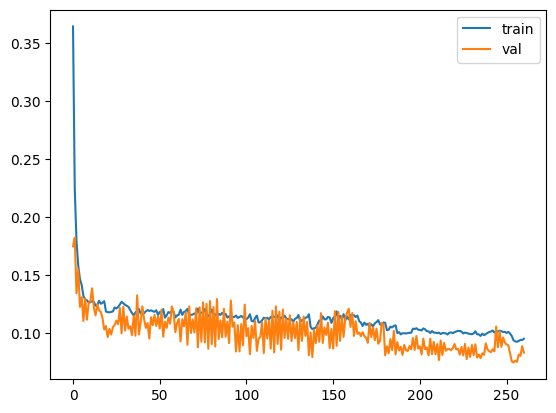

In [131]:
if args["load"] is None: # can remove this loop condition for future experiments since early stopping will also save all_train_loss and all_valid_loss quantities henceforth (Sep 24)
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="val")
    plt.legend()

In [132]:
train_data_eval = DataLoader(train_dataset,
        batch_size = len(train_dataset),
        shuffle=False,
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

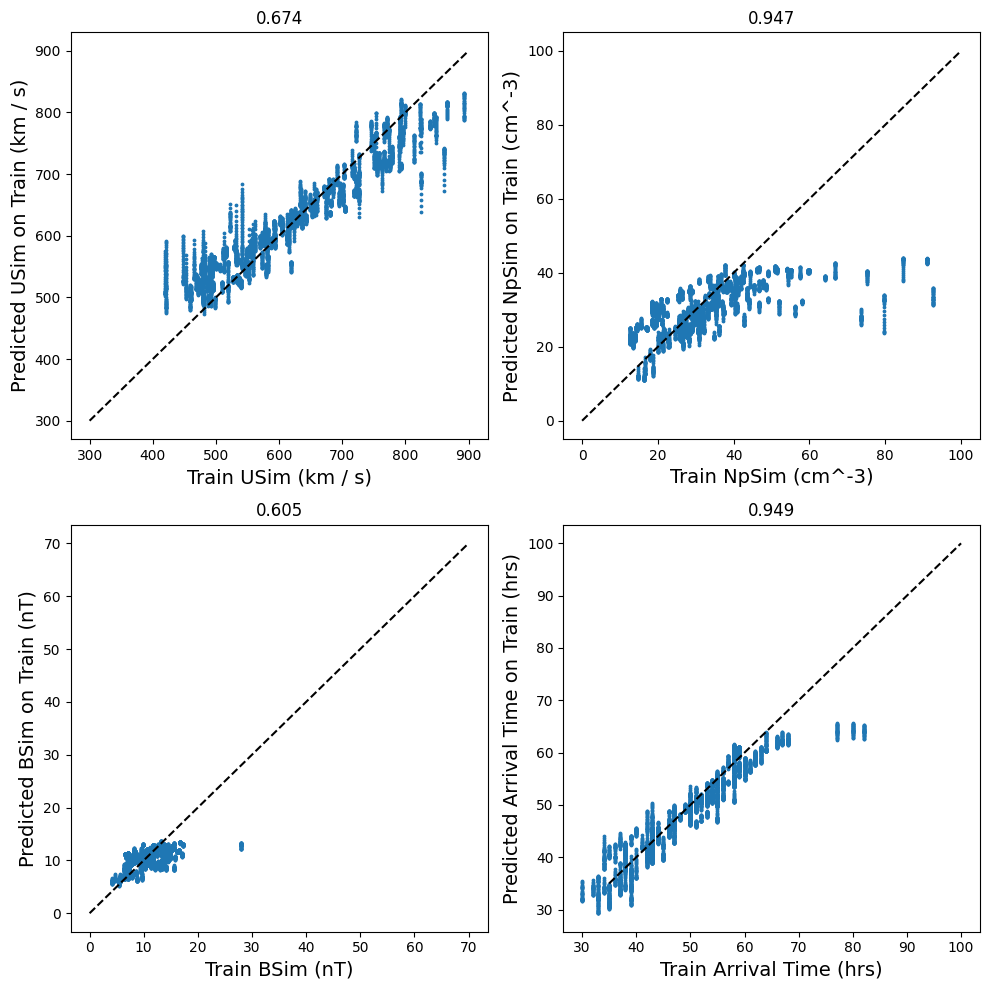

In [138]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].squeeze(1).cpu().numpy()

train_preds_unscaled.shape, train_targets_all.shape

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Train Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Train (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 0], train_preds_unscaled[:, 0])[0, 1]))

axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Train USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Train (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(train_targets_all[:, 2], train_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Train BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Train (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 2], train_preds_unscaled[:, 2])[0, 1]))

axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Train NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Train (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 3], train_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()

(1900, 4) (1900, 4)


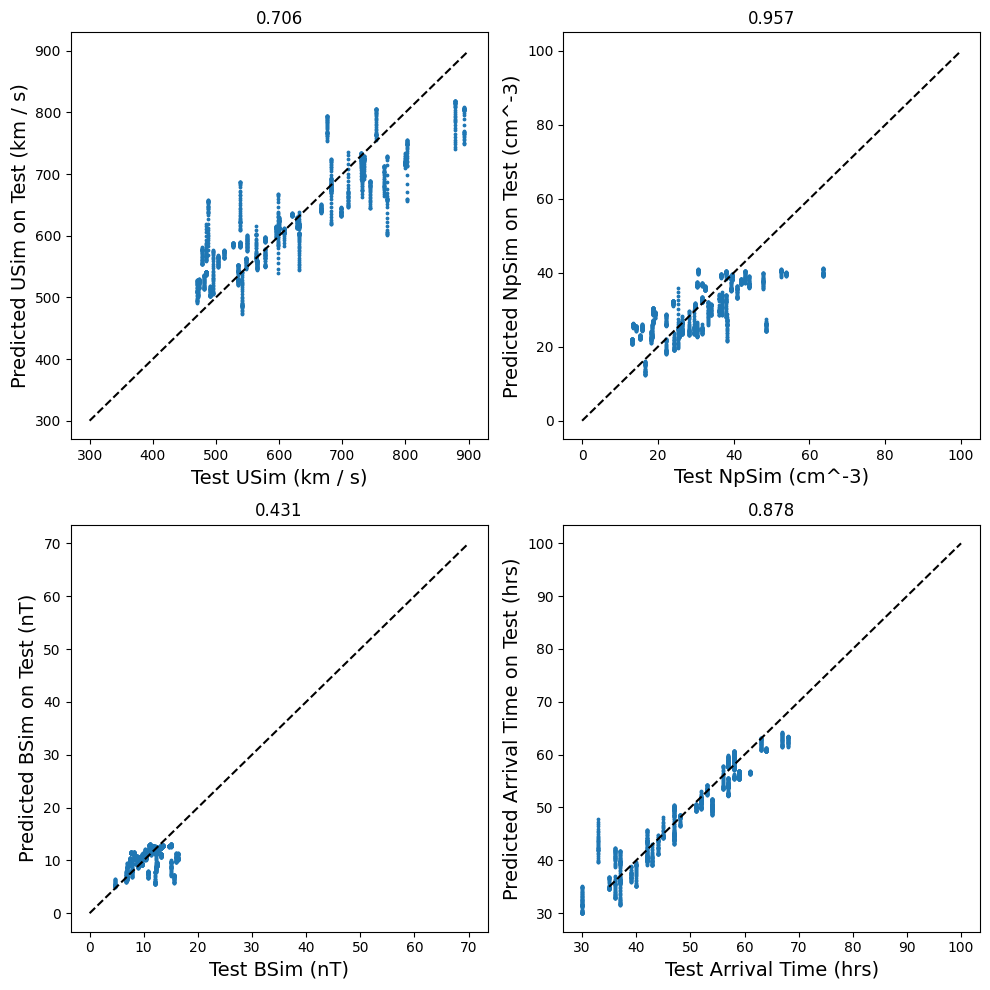

In [137]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].squeeze(1).cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

print(test_preds_unscaled.shape, true_test_arrs.shape)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Test Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Test (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled[:, 0])[0, 1]))

axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Test USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Test (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(true_test_arrs[:, 2], test_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Test BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Test (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 2], test_preds_unscaled[:, 2])[0, 1]))

axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Test NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Test (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()